In [73]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample

In [74]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24/"
nbqx_export_summary = data_dir + "export_summary_backup.csv"

camera_program = 4
um_per_px = 6.0 #um

In [75]:
# load CSV of all L4 and L2/3 crossing with NBQX blockade (array only CSV)
crossing_data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
crossing_data = pd.read_csv(crossing_data_dir + 'export_summary_crossing_PPR_array_only.csv')

def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

crossing_data

,Layer,drug,Date,Slice,Location,Recording,amp_array,ROI file
0,L4,ACSF,12/9/2024,2,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
1,L4,NBQX,12/9/2024,2,3,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...
2,L4,ACSF,10/29/2024,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
3,L4,NBQX,10/29/2024,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
4,L2/3,ACSF,10/23/2024,1,2,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
5,L2/3,NBQX,10/23/2024,1,2,4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
6,L2/3,ACSF,6/26/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...
7,L2/3,NBQX,6/26/2024,1,1,4,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...
8,L2/3,ACSF,7/1/2024,3,2,1,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...
9,L2/3,NBQX,7/1/2024,3,2,5,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...,C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...


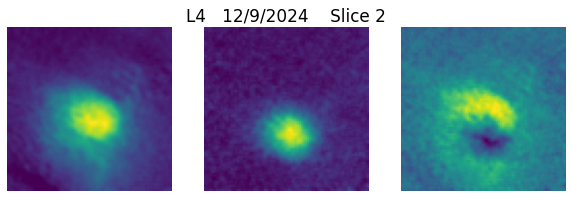

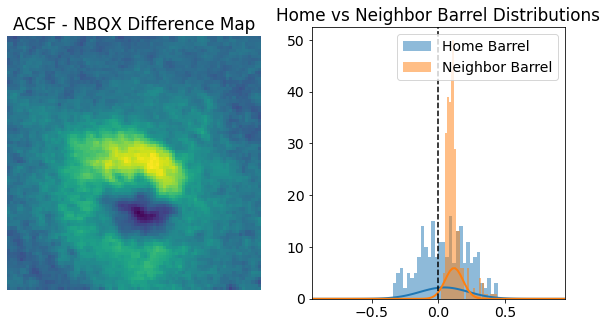

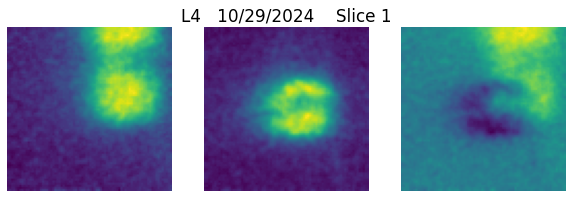

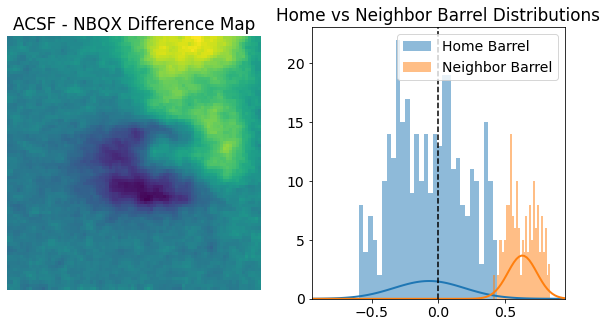

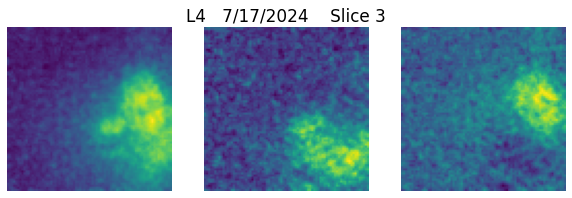

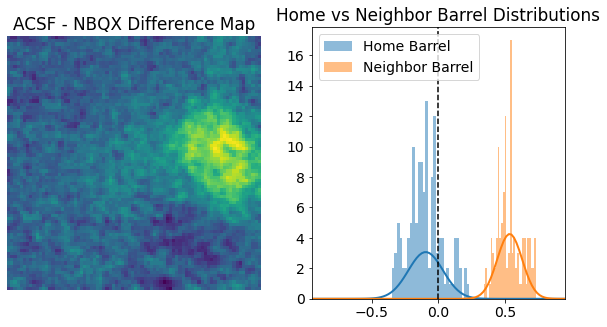

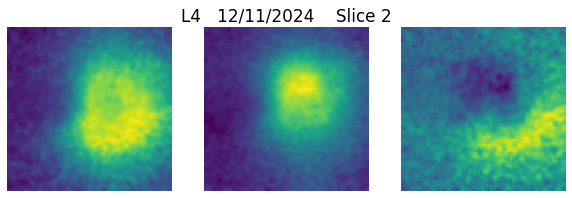

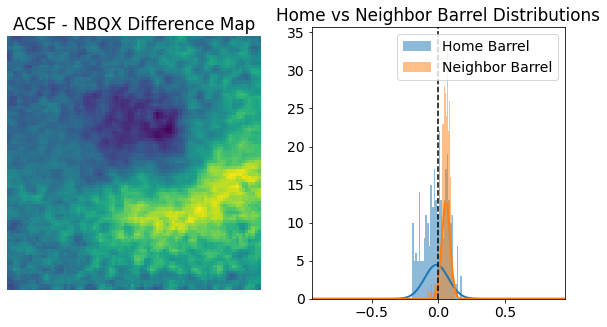

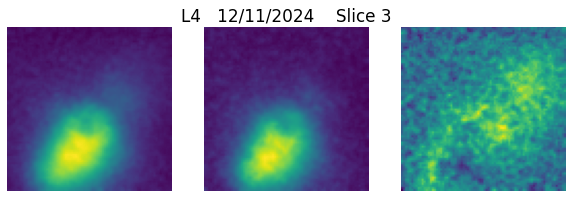

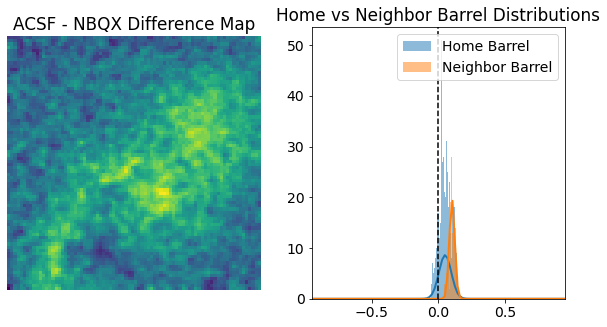

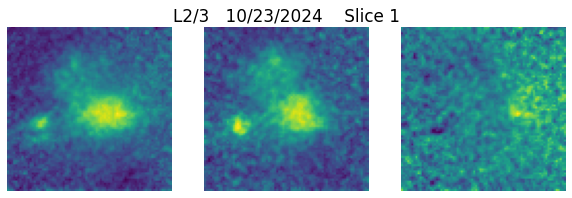

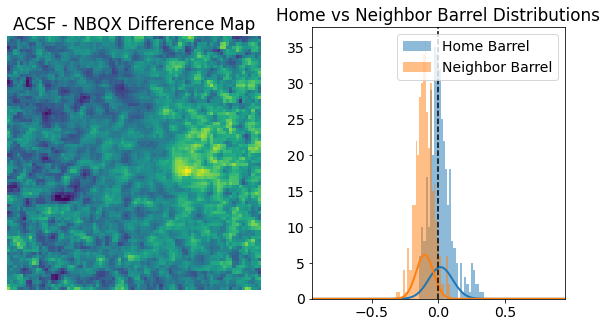

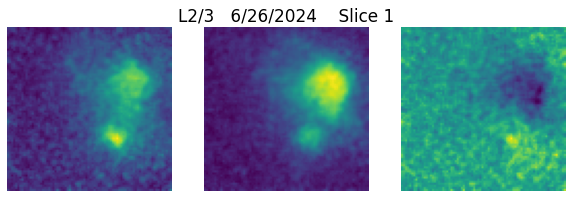

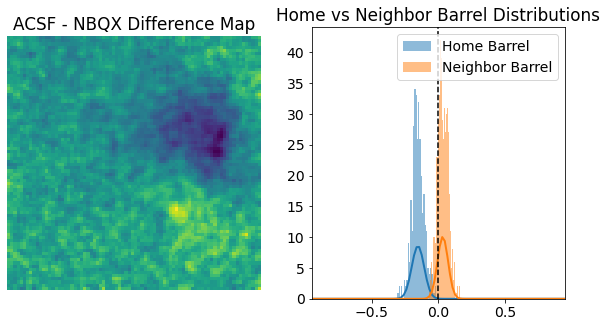

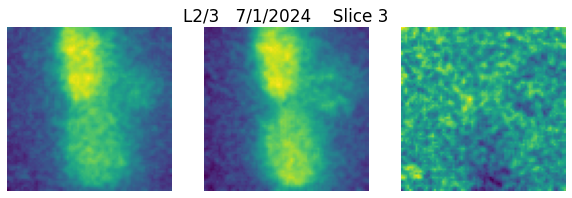

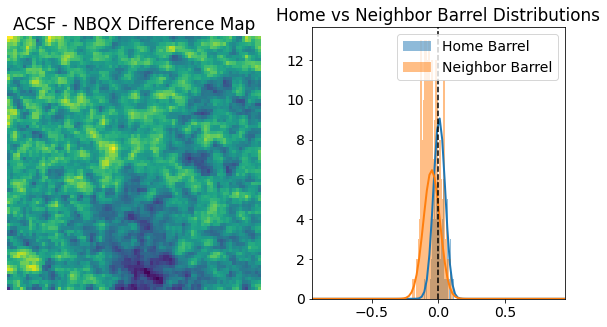

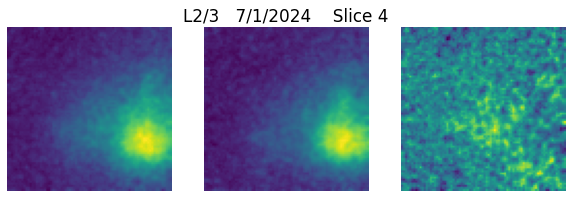

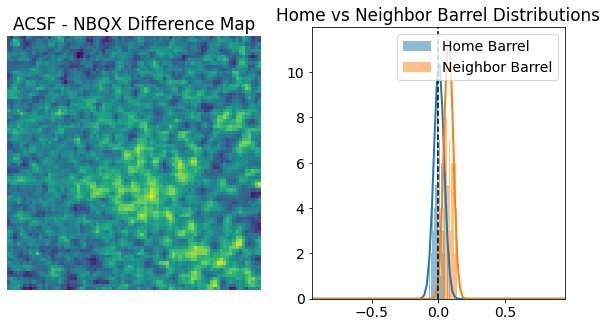

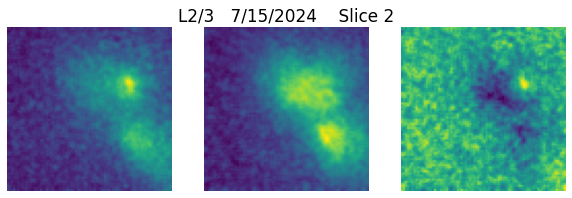

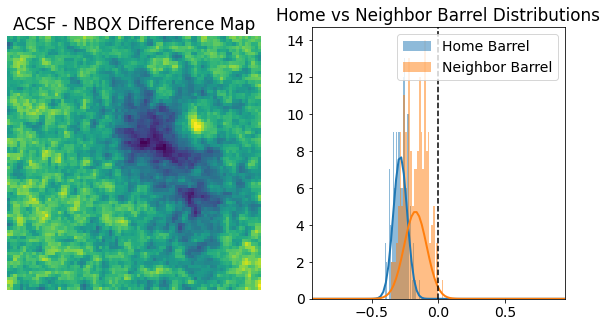

In [112]:
plt.rcParams.update({'font.size': 14})

# load the array files for each cell
survival_percentile = 50
surviving_pixels = {'L4': {'home': [], 'neighbor': []}, 
                    'L2/3': {'home': [], 'neighbor': []}}
for layer in crossing_data['Layer'].unique():
    layer_df = crossing_data[crossing_data['Layer'] == layer]
    for date in layer_df['Date'].unique():
        date_df = layer_df[layer_df['Date'] == date]
        for slic in date_df['Slice'].unique():
            slic_df = date_df[date_df['Slice'] == slic]

            fig, ax = plt.subplots(1, 3, figsize=(10, 5))
            amp_arrays = {}
            for drug in slic_df['drug'].unique():
                drug_df = slic_df[slic_df['drug'] == drug]
                amp_array = drug_df['amp_array'].values[0]
                amp_array = read_array_file(amp_array)
                i_drug = 0 if drug == 'ACSF' else 1
                amp_arrays[drug] = amp_array
                ax[i_drug].imshow(amp_array)

            # get the difference between the two arrays
            diff_array = amp_arrays['ACSF'] - amp_arrays['NBQX']
            ax[2].imshow(diff_array)
            ax[1].set_title(layer + '   ' + date + '    Slice ' + str(slic))

            # turn off spines
            for a in ax:
                a.axis('off')

            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_arrays.png')
            plt.show()

            # roi file loading
            roi_file = slic_df['ROI file'].values[0]

            # read in the ROI file
            rois = ROIFileReader(roi_file).get_roi_list()

            # convert from diode to pixel
            rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in rois]

            # first roi is home barrel, rest are neighboring barrels
            home_barrel = rois[0]
            neighbor_barrels = rois[1:]

            # get the survival_percentile% percentile of the ACSF array
            acsf_survive = np.percentile(amp_arrays['ACSF'], survival_percentile)

            # how much of the NBQX array is above the survival_percentile of the ACSF array
            nbqx_above_acsf = amp_arrays['NBQX'] > acsf_survive
            
            # count the number of pixels above the 95th percentile of the ACSF array in the home barrel
            home_ct = 0
            for point in home_barrel:
                x, y = point
                home_ct += nbqx_above_acsf[y, x]
            surviving_pixels[layer]['home'].append(home_ct)

            # count the number of pixels above the 95th percentile of the ACSF array in the neighbor barrels
            neighbor_ct = 0
            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neighbor_ct += nbqx_above_acsf[y, x]
            surviving_pixels[layer]['neighbor'].append(neighbor_ct)

            # build the ACSF -> NBQX percent change map
            percent_change_map = np.zeros_like(amp_arrays['ACSF'])
            percent_change_map[amp_arrays['ACSF'] > 0] = (amp_arrays['NBQX'][amp_arrays['ACSF'] > 0] 
                    - amp_arrays['ACSF'][amp_arrays['ACSF'] > 0]) / amp_arrays['ACSF'][amp_arrays['ACSF'] > 0]

            home_barrel_distribution = []
            neighbor_barrel_distribution = []

            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neighbor_barrel_distribution.append(diff_array[y, x])

            for point in home_barrel:
                x, y = point
                home_barrel_distribution.append(diff_array[y, x])

            # fit a normal distribution to the home barrel and neighbor barrel distributions
            home_barrel_distribution = np.array(home_barrel_distribution)
            neighbor_barrel_distribution = np.array(neighbor_barrel_distribution)
            home_mean, home_std = norm.fit(home_barrel_distribution)
            neighbor_mean, neighbor_std = norm.fit(neighbor_barrel_distribution)

            # plot ratio map and home/neighbor barrel distributions
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(diff_array)
            ax[0].set_title('ACSF - NBQX Difference Map')
            ax[0].axis('off')
            ax[1].hist(home_barrel_distribution, bins=30, alpha=0.5, label='Home Barrel')
            ax[1].hist(neighbor_barrel_distribution, bins=30, alpha=0.5, label='Neighbor Barrel')

            # plot the normal distributions
            x = np.linspace(-0.95, 0.95, 100)
            y_home = norm.pdf(x, home_mean, home_std)
            y_neighbor = norm.pdf(x, neighbor_mean, neighbor_std)
            ax[1].plot(x, y_home, 'tab:blue', linewidth=2)
            ax[1].plot(x, y_neighbor, 'tab:orange', linewidth=2)
            ax[1].set_xlim(-0.95, 0.95)

            # vertical black line at 0
            ax[1].axvline(x=0, color='black', linestyle='--')

            ax[1].set_title('Home vs Neighbor Barrel Distributions')
            ax[1].legend()
            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_distributions.png')
            plt.show()

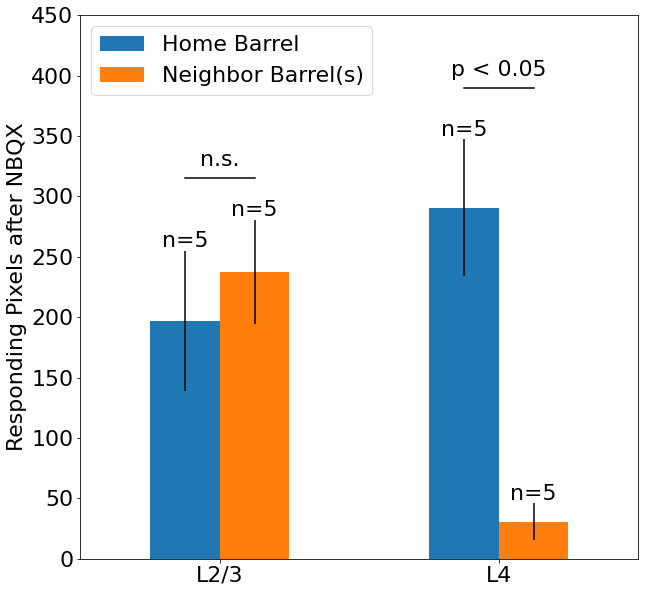

In [110]:
# set matplotlib font size
plt.rcParams.update({'font.size': 22})

# bar plot of surviving pixels, L2/3 vs L4, with error bars
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
layers = ['L2/3', 'L4']
surviving_pixels_mean = [np.mean(surviving_pixels[layer]['home']) for layer in layers]
surviving_pixels_sem = [sem(surviving_pixels[layer]['home']) for layer in layers]
ax.bar([-.125, .875], surviving_pixels_mean, yerr=surviving_pixels_sem, width=.25, label='Home Barrel')

surviving_pixels_mean = [np.mean(surviving_pixels[layer]['neighbor']) for layer in layers]
surviving_pixels_sem = [sem(surviving_pixels[layer]['neighbor']) for layer in layers]
ax.bar([.125, 1.125], surviving_pixels_mean, yerr=surviving_pixels_sem, width=.25, label='Neighbor Barrel(s)')
ax.set_ylabel('Responding Pixels after NBQX')

ax.set_xticks([0, 1])
ax.set_xticklabels(layers)
ax.set_xlim(-.5, 1.5)

# annotate sample size on each layer/barrel bar
bar_locs = [-.125, .125, .875, 1.125]
for i, layer in enumerate(layers):
    for j, barrel in enumerate(['home', 'neighbor']):
        ax.text(bar_locs[i*2 + j], np.mean(surviving_pixels[layer][barrel]) + sem(surviving_pixels[layer][barrel]) + 3, 
                'n=' + str(len(surviving_pixels[layer][barrel])), ha='center')

bar_height = [315, 390]
# significance testing: home vs neighbor barrel
for i, layer in enumerate(layers):
    t_stat, p_val = ttest_ind(surviving_pixels[layer]['home'], surviving_pixels[layer]['neighbor'])
    if p_val < 0.01:
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'p < 0.05', ha='center')

        # add line between home and neighbor barrel
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
    else:
        # add n.s. bar
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'n.s.', ha='center')
        

    
# legend in top left
ax.set_ylim(0, 450)
ax.legend(loc='upper left')
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/surviving_pixels.png')
plt.show()

In [78]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

# open export summary csv
df_nbqx = pd.read_csv(nbqx_export_summary)

# normalize latency
actual_stim_time = 48.9
df_nbqx['latency'] = df_nbqx['latency'] - actual_stim_time

# divide amp by 1000
df_nbqx['amp'] = df_nbqx['amp'] / 1000

df_nbqx

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24/export_summary_backup.csv'

both
C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_1_2_1_trace_1_rois.dat
10-23-24 1 2 1


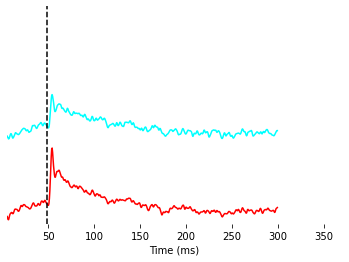

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_1_2_2_trace_1_rois.dat
10-23-24 1 2 2


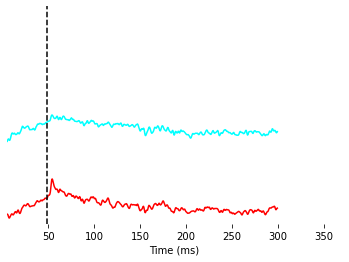

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_1_2_3_trace_1_rois.dat
10-23-24 1 2 3


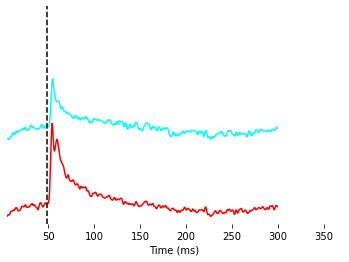

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_1_2_4_trace_1_rois.dat
10-23-24 1 2 4


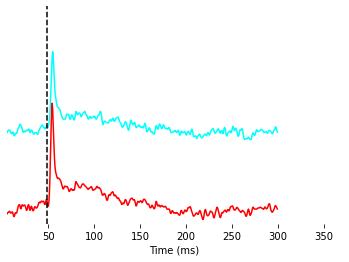

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_1_2_5_trace_1_rois.dat
10-23-24 1 2 5


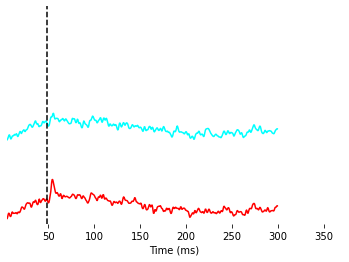

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_1_2_6_trace_1_rois.dat
10-23-24 1 2 6


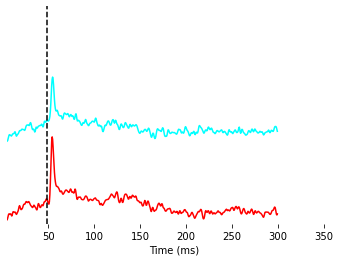

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_1_trace_2_rois.dat
10-23-24 2 1 1


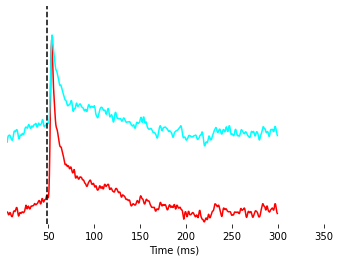

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_2_trace_2_rois.dat
10-23-24 2 1 2


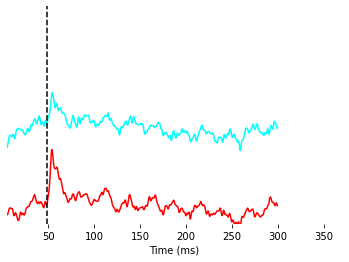

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_3_trace_2_rois.dat
10-23-24 2 1 3


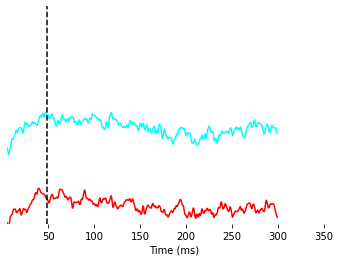

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_4_trace_2_rois.dat
10-23-24 2 1 4


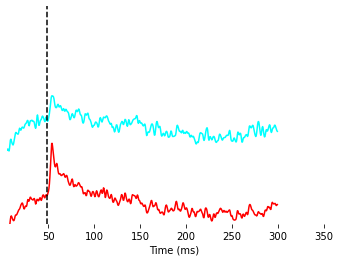

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_5_trace_2_rois.dat
10-23-24 2 1 5


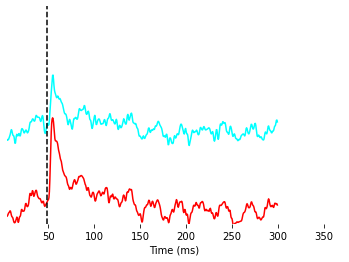

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_6_trace_2_rois.dat
10-23-24 2 1 6


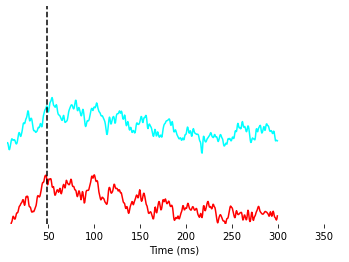

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_7_trace_2_rois.dat
10-23-24 2 1 7


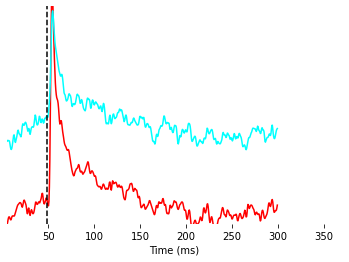

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_8_trace_2_rois.dat
10-23-24 2 1 8


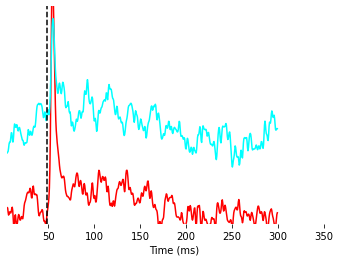

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_9_trace_2_rois.dat
10-23-24 2 1 9


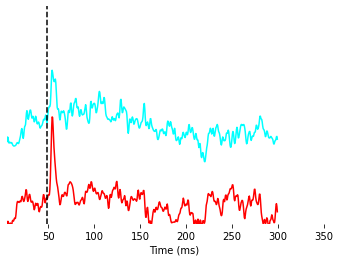

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_10_trace_2_rois.dat
10-23-24 2 1 10


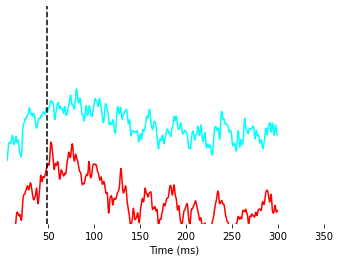

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_11_trace_2_rois.dat
10-23-24 2 1 11


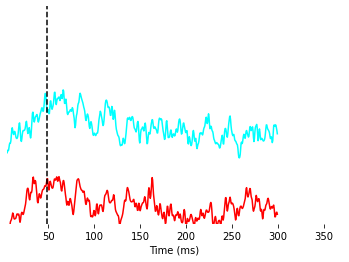

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_12_trace_2_rois.dat
10-23-24 2 1 12


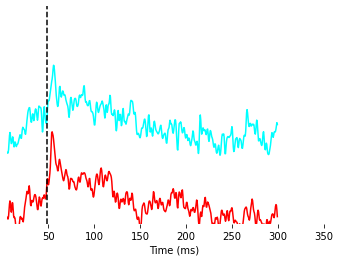

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_2_1_13_trace_2_rois.dat
10-23-24 2 1 13


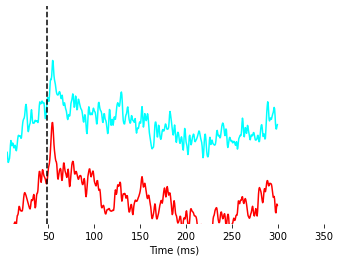

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_3_1_1_trace_3_rois.dat
10-23-24 3 1 1


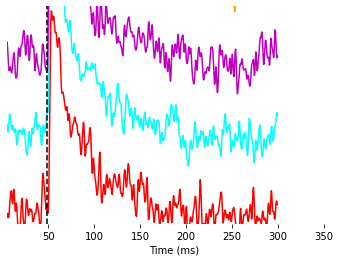

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_3_1_2_trace_3_rois.dat
10-23-24 3 1 2


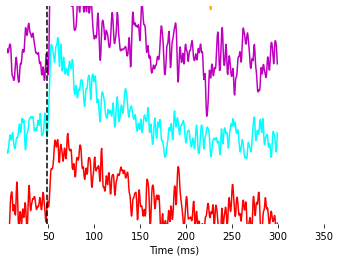

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_3_1_3_trace_3_rois.dat
10-23-24 3 1 3


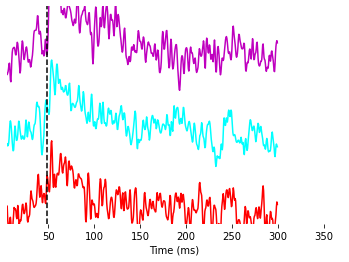

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_3_1_4_trace_3_rois.dat
10-23-24 3 1 4


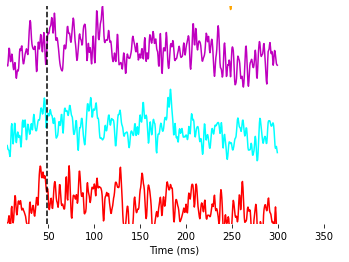

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_3_1_5_trace_3_rois.dat
10-23-24 3 1 5


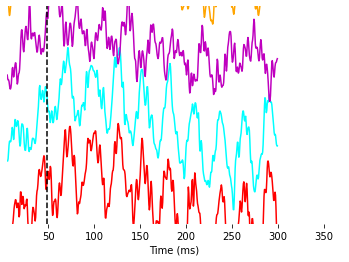

C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24\converted_zda/_3_1_6_trace_3_rois.dat
10-23-24 3 1 6


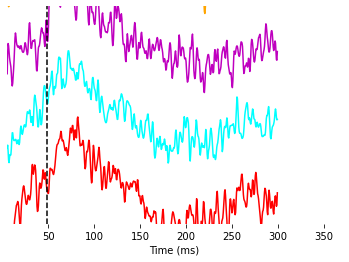

In [ ]:
# plot traces
for i, df in enumerate([df_nbqx]): # , df_nbqx, df_rand]):
    n_plots = 400
    print(['both', 'nbqx', 'rand'][i])
    for date in df['Date'].unique():
        df_date = df[df['Date'] == date]
        for slic_id in df_date['Slice'].unique():
            df_slic = df_date[df_date['Slice'] == slic_id]
            for loc_id in df_slic['Location'].unique():
                df_loc = df_slic[df_slic['Location'] == loc_id]
                for rec_id in df_loc['Recording'].unique():
                    df_rec = df_loc[df_loc['Recording'] == rec_id]


                    if n_plots == 0:
                        continue

                    # trace filename
                    trace_filename = df_rec['trace'].values[0]
                    try:
                        trace = read_traces_file(trace_filename)
                    except FileNotFoundError:
                        print("File not found:")
                        continue
                    print(trace_filename)

                    tm = TraceMetrics(trace)
                    print(date, slic_id, loc_id, rec_id)
                    tm.show_traces(measure_window=[10, 740], 
                            legend=False, 
                            colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                    'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                            stim_time=actual_stim_time,
                            ylim=[-0.1, 1.3],
                            headroom=.5,
                                    )
                    n_plots -= 1
                    
                    """tm.frequency_decomposition(measure_window=[94, 140],
                                                    xlim=[20, 400])"""

In [ ]:
# plot distributions of latency, half-width, and amplitude of neightboring barrels
# divided by 

# catalog df
catalog_df = pd.read_csv("C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/AnnaW-blockade/trial_df_edit.csv")


distributions_none = {'latency': [], 'halfwidth': [], 'amp': []}
distributions_drug = {'latency': [], 'halfwidth': [], 'amp': []}
recording_pairs = {'latency': {}, 'halfwidth': {}, 'amp': {}}

df_list = [df_both, df_nbqx]
#df_list = [df_rand]
file_out_name = "rand" if len(df_list) == 1 else "barrels"

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
i_color = -1

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i_drug, drug_df in enumerate(df_list):
    neighbor_df = drug_df[drug_df['ROI'] != 1]
    # exclude 7/25/24 ROI 2 (dependent measurement with ROI 3 from same recordings) -- drop rows from neighbor_df
    neighbor_df = neighbor_df.drop(neighbor_df[(neighbor_df['ROI'] == 2) & (neighbor_df['Date'] == '7/25/2024')].index)

    # latency, halfwidth, and amplitude must be positive
    neighbor_df = neighbor_df[(neighbor_df['latency'] > 0) & 
                              (neighbor_df['latency'] < 20) & 
                              (neighbor_df['halfwidth'] > 0) & 
                              (neighbor_df['amp'] > 0)]

    for date in neighbor_df['Date'].unique():
        date_df = neighbor_df[neighbor_df['Date'] == date]
        for slic_id in date_df['Slice'].unique():
            slic_df = date_df[date_df['Slice'] == slic_id]
            for loc_id in slic_df['Location'].unique():
                loc_df = slic_df[slic_df['Location'] == loc_id]
                i_color = (i_color + 1) % len(colors)
                for rec_id in loc_df['Recording'].unique():

                    catalog_formatted_date = date.replace('-', '/')
                    if len(catalog_formatted_date.split("/")[-1]) < 4:
                        catalog_formatted_date = catalog_formatted_date[:-2] + '20' + catalog_formatted_date[-2:]

                    # get the corresponding catalog entry
                    catalog_entry = catalog_df[(catalog_df['Date'] == catalog_formatted_date) & 
                                                (catalog_df['Slice#'] == slic_id) & 
                                                (catalog_df['Location'] == loc_id) & 
                                                (catalog_df['Recording'] == rec_id)]
                    neighbor_df_subset = loc_df[(neighbor_df['Recording'] == rec_id)]
                    if len(catalog_entry) == 0:
                        print("No catalog entry for", catalog_formatted_date, slic_id, loc_id, rec_id)
                        continue
                    drug = catalog_entry['Drug'].values[0]
                    is_steady_state = catalog_entry['steady_state'].values[0]

                    if drug == 'None' or (i_drug == 0 and drug == 'Both') or (i_drug == 1 and drug == 'NBQX' and is_steady_state == 'y'):
                        # plot latency, hlaf-width, and amplitude in the corresponding plot (ACSF or both)
                        i_x = 0 if drug == 'None' else 1
                        if drug != 'None':
                            print(neighbor_df_subset['Date'].values[0], len(neighbor_df_subset), neighbor_df_subset['ROI'].values, neighbor_df_subset['Recording'].values, drug)
                        for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):

                            # halfwidth and latency must be positive
                            if metric == 'halfwidth' or metric == 'latency':
                                neighbor_df_subset = neighbor_df_subset[neighbor_df_subset[metric] > 0]

                            # plot 7/15/2024 amplitude in black
                            color = colors[i_color]

                            x_jitter = np.random.normal(0, 0.1, len(neighbor_df_subset))

                            if len(neighbor_df_subset) > 0:
                                ax[i_plot].scatter(i_x + x_jitter, neighbor_df_subset[metric], alpha=0.5, c=color)
                                ax[i_plot].set_xticks([0, 1])
                                ax[i_plot].set_ylabel(metric)

                                # add to distribution
                                if drug == 'None':
                                    distributions_none[metric].extend(neighbor_df_subset[metric].values)
                                else:
                                    distributions_drug[metric].extend(neighbor_df_subset[metric].values)

                                # add to recording pairs

                                if date + str(slic_id) + str(loc_id) not in recording_pairs[metric]:
                                    recording_pairs[metric][date + str(slic_id) + str(loc_id)] = {}
                                recording_pairs[metric][date + str(slic_id) + str(loc_id)][drug] = neighbor_df_subset[metric].values

# plot lines between pairs of recordings
for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):
    for recording_pair in recording_pairs[metric].values():
        if 'None' in recording_pair and 'NBQX' in recording_pair:
            for i_roi in range(len(recording_pair['None'])):
                if i_roi >= len(recording_pair['NBQX']):
                    continue
                color = 'r-' if recording_pair['None'][i_roi] < recording_pair['NBQX'][i_roi] else 'k-'
                ax[i_plot].plot([0, 1], [recording_pair['None'][i_roi], recording_pair['NBQX'][i_roi]], color, alpha=0.5)  
        if 'None' in recording_pair and 'Both' in recording_pair:
            for i_roi in range(len(recording_pair['None'])):
                if i_roi >= len(recording_pair['Both']):
                    continue
                color = 'r-' if recording_pair['None'][i_roi] < recording_pair['Both'][i_roi] else 'k-'
                ax[i_plot].plot([0, 1], [recording_pair['None'][i_roi], recording_pair['Both'][i_roi]], color, alpha=0.5)


# plot distributions as boxplots over the existing scatter plots
for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):
    ax[i_plot].boxplot([distributions_none[metric], distributions_drug[metric]], positions=[0, 1])
    print(metric, 'None mean', np.mean(distributions_none[metric]), "+/-", sem(distributions_none[metric]),
          'Drug mean', np.mean(distributions_drug[metric]), "+/-", sem(distributions_drug[metric]))
    ax[i_plot].set_xticks([0, 1])
    ax[i_plot].set_xticklabels(['ACSF', '+NBQX'])
    ax[i_plot].set_ylabel({'latency': 'Latency (ms)', 'halfwidth': 'Half-width (ms)', 'amp': 'Δf/f'}[metric])

# turn off spines
for i_plot in range(3):
    ax[i_plot].spines['top'].set_visible(False)
    ax[i_plot].spines['right'].set_visible(False)


# conduct significance tests (Welch's t-test, one-sided)
for i_plot, metric in enumerate(['latency', 'halfwidth', 'amp']):
    '''print(metric)
    t_stat, pval = ttest_ind(distributions_none[metric], distributions_drug[metric], equal_var=False, alternative='less')
    pval = min(pval, 1- pval)  # some one-sided tests are greater, some are lesser. Automatically choose the smaller p-value
    print(t_stat, 'pval', pval)'''

    # p-vals from barrel averages:
    pval = [0.0506, 0.04, 0.290][i_plot]

    if pval < 0.05:
        # plot significance line
        ax[i_plot].plot([0, 1], [np.max([np.max(distributions_none[metric]), np.max(distributions_drug[metric])])]*2, 'k-')
        ax[i_plot].text(0.5, np.max([np.max(distributions_none[metric]), np.max(distributions_drug[metric])]), 'p = ' + str(pval)[:4], ha='center', va='bottom')

# increase space between subplots
plt.tight_layout()
plt.savefig("P:/John/crossing-paper/input/output-drug-compare" + file_out_name + ".png")
plt.show()

NameError: name 'df_both' is not defined

In [ ]:
# now generate either random barrel samples or striped barrel ROIs to extract latency
# create random ROI samples of 1 pixel, or stripes of 5 pixel width. Stripes parallel to barrel axis
# Generate ROI files of specified sizes
roi_type = "random"  # set to "stripes" or "random"

lock_roi = True  # set to True to lock in ROIs, as safeguard to avoid overwriting

data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/AnnaW-blockade/combined-nbqx-both/"
roi_sampler = RandomROISample(1)
data_file_map = {}
distance_map = {}
for subdir, dirs, files in os.walk(data_dir):
    for file in files:
        if 'roi.dat' in file:

            # load barrel file (lists of lists of diode numbers)
            barrel_rois = ROIFileReader(subdir + '/' + file).get_roi_list()

            # convert from diode to pixel
            barrel_rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in barrel_rois]
            
            
            brc = Barrel_ROI_Creator(max_rois=40)
            new_rois = None

            if roi_type == "random" and not lock_roi:
                new_rois = brc.get_rand_rois(barrel_rois)  # default: 1 px per ROI, 100 ROIs per barrel

                # convert pixels to diode numbers
                roi_cr = ROICreator(None)
                for k in new_rois:
                    new_rois[k] = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois[k]]

            # write each new ROI to a separate file
            rfw = ROIFileWriter()
            selected_zda_dir = subdir 
            subdir_shortened = subdir.split('\\selected_zda')[0]
            if subdir_shortened not in data_file_map:
                data_file_map[subdir_shortened] = {}
            data_file_map[subdir_shortened][file] = []
            for barrel_idx in new_rois:
                roi_file = brc.get_rand_roi_filename(selected_zda_dir, barrel_idx, file)
                if roi_type == "stripes":
                    roi_file = brc.get_stripe_roi_filename(selected_zda_dir, barrel_idx, file)
                if not lock_roi:
                    rfw.write_regions_to_dat(roi_file, new_rois[barrel_idx])
                    print("Wrote", roi_file)
                data_file_map[subdir_shortened][file].append(roi_file)

TypeError: 'NoneType' object is not iterable

## 